In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import os
import itertools as it
import shutil

import sqlite3
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
from matplotlib import cm
import cmocean
from scipy.optimize import curve_fit
import ipyvolume as ipv

import kelp_compute
import kelp_analyze
import discrete_plot
import error_visualize

# Compare Asymptotics to FD

In [4]:
def cori_asymptotics_study_plot_irrad_fixed_iops(study_name, a_water, b, avg_irrad=False, log_data=True):
    """
    Make two plots:
    - perceived irradiance vs. depth for FD and all asymptotics
    - error vs. number of scatters
    """
    base_dir = os.path.join(os.environ['SCRATCH'], 'kelp-results')
    study_dir = os.path.join(base_dir, study_name)
    db_path = os.path.join(study_dir, '{}.db'.format(study_name))
    conn = sqlite3.connect(db_path)
    
    # Get run data from .nc files
    run_list = kelp_analyze.query_results(conn, study_name, a_water=a_water, b=b)
    # Assume that there's only one FD run for each IOP set
    fd_run_ds = [run for run in run_list if run['fd_flag'][:] == True][0]
    fd_perceived_irrad = kelp_analyze.calculate_perceived_irrad(
        fd_run_ds['p_kelp'][:],
        fd_run_ds['irrad'][:]
    )
    if avg_irrad:
        fd_perceived_irrad = np.mean(fd_run_ds['irrad'][:], axis=(0,1))
    
    asymptotics_run_dict = {
        int(run_ds['num_scatters'][:]): run_ds
        for run_ds in run_list
        if run_ds['fd_flag'][:] != True
    }
    
    nz_fd = fd_run_ds['nz'][:]
    zmin = 0
    zmax = fd_run_ds['zmax'][:]
    dz_fd = (zmax-zmin)/nz_fd
    z_fd = dz_fd * (np.arange(nz_fd) + 0.5)
    
    plt.figure(1, figsize=[10,8])
    plt.plot(z_fd, fd_perceived_irrad, 'o-', label='FD')
    
    num_scatters_list = sorted(asymptotics_run_dict.keys())
    for num_scatters in num_scatters_list:
        run_ds = asymptotics_run_dict[num_scatters]
        perceived_irrad = kelp_analyze.calculate_perceived_irrad(
            run_ds['p_kelp'][:], 
            run_ds['irrad'][:]
        )
        if avg_irrad:
            perceived_irrad = np.mean(run_ds['irrad'][:], axis=(0,1))
        
        if log_data:
            perceived_irrad[perceived_irrad<=0] = np.nan
        
        nz_as = run_ds['nz'][:]
        dz_as = (zmax-zmin)/nz_as
        z_as = dz_as * (np.arange(nz_as) + 0.5)

        plt.plot(z_as, perceived_irrad, 'o-', label='n={}'.format(num_scatters))
        
        # TODO: Calculate error & save to list
        
    if log_data:
        plt.yscale('log')
    plt.figure(1)
    plt.legend()
        
    # TODO: Plot error
    # plt.figure(2)

In [5]:
def get_as_param_lists(conn, study_name):
    # Get a, b values
    cursor = conn.execute('''
    SELECT a_water, b, num_scatters
    FROM {study_name}
    '''.format(study_name=study_name))

    # Get all unique values of a_water, b
    types = (float, float, int)
    a_water_list, b_list, num_scatters_list = [
        sorted(
            set(
                map(
                    t,
                    col
                )
            )
        )
        for col, t in zip(
            zip(*cursor.fetchall()), 
            types
        )
    ]
    
    return a_water_list, b_list, num_scatters_list
    
def analyze_asymptotics_study(study_name, num_scatters):
    # Open db
    base_dir = os.path.join(os.environ['SCRATCH'], 'kelp-results')
    study_dir = os.path.join(base_dir, study_name)
    db_path = os.path.join(study_dir, '{}.db'.format(study_name))
    conn = sqlite3.connect(db_path)
    
    a_water_list, b_list, num_scatters_list = get_as_param_lists(conn, study_name)
    
    print("a_water_list = {}".format(a_water_list))
    print("b_list = {}".format(b_list))
    print("num_scatters_list = {}".format(num_scatters_list))
    
    perceived_irrad_dict = {}
    fd_flux_dict = {}
    asym_flux_dict = {}
    compute_time_dict = {}
    abs_err_dict = {}
    rel_err_dict = {}

    for a_water in a_water_list:
        for b in b_list:
            for num_scatters in num_scatters_list:
                # Compare to FD
                # Assume there's only one run
                # that matches largest grid
                fd_results = kelp_analyze.query_results(
                    conn,
                    study_name,
                    a_water=a_water,
                    b=b,
                    fd_flag=True
                )[0]
                
                zmin = 0
                zmax = fd_results['zmax'][:]
                rope_spacing = fd_results['rope_spacing'][:]
                nz_fd = fd_results['nz'][:]
                dz_fd = (zmax-zmin) / nz_fd
                ft = fd_results['ft'][:]
                
                p_kelp = fd_results['p_kelp'][:]
                fd_irrad = fd_results['irrad'][:]
                fd_perceived_irrad = kelp_analyze.calculate_perceived_irrad(p_kelp, fd_irrad)
                fd_flux = kelp_analyze.calculate_flux(fd_perceived_irrad, p_kelp, ft, rope_spacing, zmin, zmax)

                asym_perceived_irrad, asym_flux, abs_err, rel_err, compute_time = kelp_analyze.compute_err(
                    conn, 
                    study_name, 
                    fd_perceived_irrad,
                    a_water=a_water,
                    b=b,
                    num_scatters=num_scatters,
                    fd_flag=False
                )

                perceived_irrad_dict[(a_water, b, num_scatters)] = asym_perceived_irrad
                fd_flux_dict[(a_water, b)] = fd_flux
                asym_flux_dict[(a_water, b, num_scatters)] = asym_flux
                compute_time_dict[(a_water, b, num_scatters)] = compute_time
                abs_err_dict[(a_water, b, num_scatters)] = abs_err
                rel_err_dict[(a_water, b, num_scatters)] = rel_err
    return perceived_irrad_dict, fd_flux_dict, asym_flux_dict, abs_err_dict, rel_err_dict, compute_time_dict
   

# Compare Asymptotics to FD, fixed IOPs

In [6]:
study_name = 'as_n88_9ax9b_new'

In [7]:
a_water = 0.4
#a_water = 0.30000000000000004
#b = 0.6000000000000001
b = 0.4

In [8]:
base_dir = os.path.join(os.environ['SCRATCH'], 'kelp-results')
study_dir = os.path.join(base_dir, study_name)
db_path = os.path.join(study_dir, '{}.db'.format(study_name))
conn = sqlite3.connect(db_path)
a_water_list, b_list, num_scatters_list = get_as_param_lists(conn, study_name)

## All Irradiances

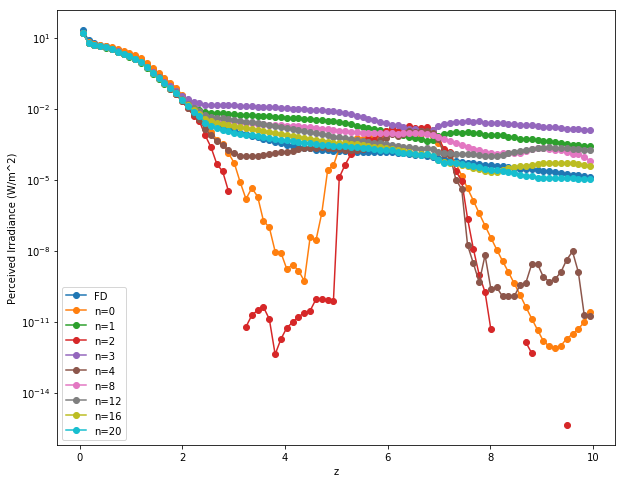

In [9]:
cori_asymptotics_study_plot_irrad_fixed_iops(study_name, a_water, b, log_data=True)
plt.xlabel('z')
plt.ylabel('Perceived Irradiance (W/m^2)')
#plt.hlines(50, 0, 10)

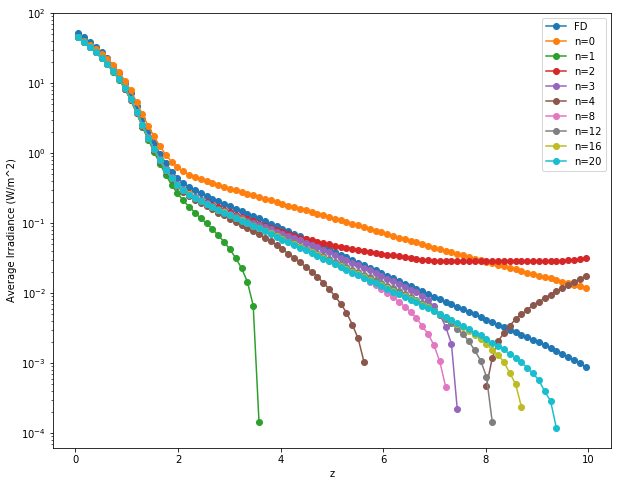

In [10]:
cori_asymptotics_study_plot_irrad_fixed_iops(study_name, a_water, b, avg_irrad=True, log_data=True)
plt.xlabel('z')
plt.ylabel('Average Irradiance (W/m^2)')
#plt.hlines(50, 0, 10)

## Single num-scatter Irradiances

In [11]:
num_scatters = 0
fd_res = kelp_analyze.query_results(conn, study_name, a_water=a_water, b=b, num_scatters=0, fd_flag=True)[0]
as_res = kelp_analyze.query_results(conn, study_name, a_water=a_water, b=b, num_scatters=num_scatters, fd_flag=False)[0]

In [12]:
perceived_irrad_dict, fd_flux_dict, asym_flux_dict, abs_err_dict, rel_err_dict, compute_time_dict  = (
    analyze_asymptotics_study(study_name, num_scatters)
)

a_water_list = [0.0, 0.05, 0.1, 0.15000000000000002, 0.2, 0.25, 0.30000000000000004, 0.35000000000000003, 0.4]
b_list = [0.0, 0.2, 0.4, 0.6000000000000001, 0.8, 1.0, 1.2000000000000002, 1.4000000000000001, 1.6]
num_scatters_list = [0, 1, 2, 3, 4, 8, 12, 16, 20]


In [13]:
zmin = 0
zmax = fd_res['zmax'][:]
rope_spacing = fd_res['rope_spacing'][:]
ft = fd_res['ft'][:]
smin = -rope_spacing/2

nz_fd = fd_res['nz'][:]
dz_fd = (zmax-zmin)/nz_fd
ns_fd = fd_res['ns'][:]
ds_fd = rope_spacing / ns_fd
s_fd = smin + ds_fd * (np.arange(ns_fd) + 0.5)
z_fd = zmin + dz_fd * (np.arange(nz_fd) + 0.5)
p_kelp_fd = fd_res['p_kelp'][:]
frond_area_fd = ds_fd**2 * dz_fd / ft * np.sum(p_kelp_fd, axis=(0,1))
irrad_fd = fd_res['irrad'][:]
perceived_irrad_fd = kelp_analyze.calculate_perceived_irrad(p_kelp_fd, irrad_fd)
zwe_fd, fawe_fd, piwe_fd, flux_fd = kelp_analyze.calculate_flux(perceived_irrad_fd, p_kelp_fd, ft, rope_spacing, zmin, zmax)

nz_as = as_res['nz'][:]
dz_as = (zmax-zmin)/nz_as
ns_as = as_res['ns'][:]
ds_as = rope_spacing / ns_as
s_as = smin + ds_as * (np.arange(ns_as) + 0.5)
z_as = zmin + dz_as * (np.arange(nz_as) + 0.5)
p_kelp_as = as_res['p_kelp'][:]
frond_area_as = ds_as**2 * dz_as / ft * np.sum(p_kelp_as, axis=(0,1))
irrad_as = as_res['irrad'][:]
perceived_irrad_as = kelp_analyze.calculate_perceived_irrad(p_kelp_as, irrad_as)
zwe_as, fawe_as, piwe_as, flux_as = kelp_analyze.calculate_flux(perceived_irrad_as, p_kelp_as, ft, rope_spacing, zmin, zmax)

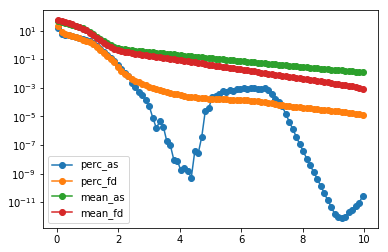

In [14]:
plt.plot(z_as, perceived_irrad_as, 'o-', label='perc_as')
plt.plot(z_fd, perceived_irrad_fd, 'o-', label='perc_fd')
plt.plot(z_as, np.mean(irrad_as, axis=(0,1)), 'o-', label='mean_as')
plt.plot(z_fd, np.mean(irrad_fd, axis=(0,1)), 'o-', label='mean_fd')
plt.legend()
plt.yscale('log')

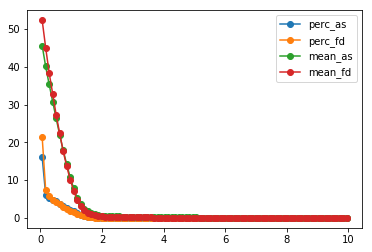

In [15]:
plt.plot(z_as, perceived_irrad_as, 'o-', label='perc_as')
plt.plot(z_fd, perceived_irrad_fd, 'o-', label='perc_fd')
plt.plot(z_as, np.mean(irrad_as, axis=(0,1)), 'o-', label='mean_as')
plt.plot(z_fd, np.mean(irrad_fd, axis=(0,1)), 'o-', label='mean_fd')
plt.legend()

/global/homes/o/oevans/local/miniconda3/envs/kelp/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in log10
  if sys.path[0] == '':


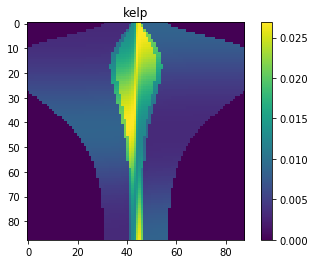

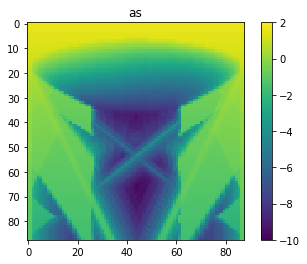

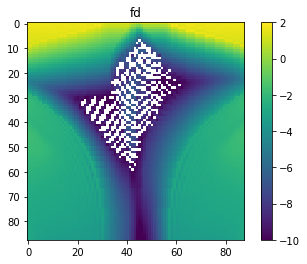

In [16]:
plt.figure()
plt.imshow(p_kelp_fd[:,44,:].T)
plt.title('kelp')
plt.colorbar()

plt.figure()
plt.imshow(np.log10(irrad_as[:,12,:].T), vmin=-10, vmax=2)
plt.title('as')
plt.colorbar()

plt.figure()
plt.imshow(np.log10(irrad_fd[:,44,:].T), vmin=-10, vmax=2)
plt.title('fd')
plt.colorbar()

In [17]:
discrete_plot.volshow_zoom_correct_scale(s_as, s_as, z_as, np.log(irrad_as), zoom_factor=0)

In [18]:
discrete_plot.volshow_zoom_correct_scale(s_fd, s_fd, z_fd, np.log(irrad_fd), zoom_factor=0)

/global/u2/o/oevans/python/packages/ipyvolume/ipyvolume/serialize.py:66: RuntimeWarning: invalid value encountered in true_divide
  gradient = gradient / np.sqrt(gradient[0]**2 + gradient[1]**2 + gradient[2]**2)


## Radiant Fluxes vs. num_scatters

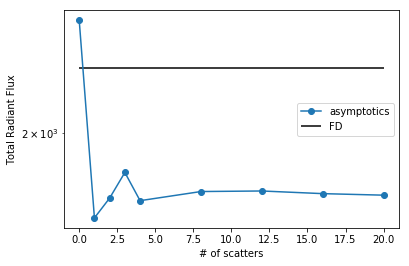

In [19]:
plt.plot(num_scatters_list, [asym_flux_dict[(a_water, b, n)] for n in num_scatters_list], 'o-', label='asymptotics')
plt.hlines(flux_fd, min(num_scatters_list), max(num_scatters_list), label='FD')
plt.xlabel('# of scatters')
plt.ylabel('Total Radiant Flux')
plt.legend(loc='right')
plt.yscale('log')

In [20]:
flux_list = []
fd_res = kelp_analyze.query_results(conn, study_name, a_water=a_water, b=b, num_scatters=0, fd_flag=True)[0]
p_kelp_fd = fd_res['p_kelp'][:]
irrad_fd = fd_res['irrad'][:]
perceived_irrad_fd = kelp_analyze.calculate_perceived_irrad(p_kelp_fd, irrad_fd)
_, _, _, flux_fd = kelp_analyze.calculate_flux(perceived_irrad_fd, p_kelp_fd, ft, rope_spacing, zmin, zmax)

for num_scatters in num_scatters_list:
    as_res = kelp_analyze.query_results(conn, study_name, a_water=a_water, b=b, num_scatters=num_scatters, fd_flag=False)[0]
    p_kelp_as = as_res['p_kelp'][:]
    irrad_as = as_res['irrad'][:]
    perceived_irrad_as = kelp_analyze.calculate_perceived_irrad(p_kelp_as, irrad_as)
    _, _, _, flux_as = kelp_analyze.calculate_flux(perceived_irrad_as, p_kelp_as, ft, rope_spacing, zmin, zmax)
    flux_list.append(flux_as)

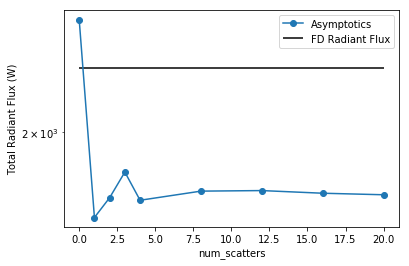

In [21]:
plt.plot(num_scatters_list, flux_list,'o-', label='Asymptotics')
plt.hlines(flux_fd, min(num_scatters_list), max(num_scatters_list), label='FD Radiant Flux')
plt.xlabel('num_scatters')
plt.ylabel('Total Radiant Flux (W)')
plt.legend()
plt.yscale('log')

## Difference in Radiant Fluxes

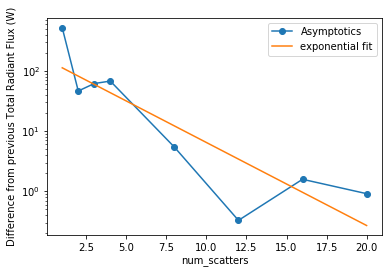

In [22]:
n = np.array(num_scatters_list[1:], dtype='float')
flux_diff = np.abs(np.diff(flux_list) / np.diff(num_scatters_list))
plt.plot(n, flux_diff,'o-', label='Asymptotics')

linear_f = lambda x, m, b: m*x + b
exp_f = lambda x, a, m: a*np.exp(m*x)
# Power law fit
popt, pcov = curve_fit(linear_f, n, np.log(flux_diff))
m, b = popt

plt.plot(n, exp_f(n, np.exp(b), m), '-', label='exponential fit')

plt.xlabel('num_scatters')
plt.ylabel('Difference from previous Total Radiant Flux (W)')
#plt.xscale('log')
plt.yscale('log')
plt.legend()

# Get flux and  flux diff exponents for all IOPs

In [36]:
flux_diff_exponents = np.zeros([len(a_water_list), len(b_list)])
flux_grid_as = np.zeros([len(a_water_list), len(b_list), len(num_scatters_list)])
flux_grid_fd = np.zeros([len(a_water_list), len(b_list), 1])
n = np.array(num_scatters_list[1:], dtype='float')
linear_f = lambda x, m, q: m*x + q
exp_f = lambda x, a, m: a*np.exp(m*x)

zmin = 0
zmax = fd_res['zmax'][:]
ft = fd_res['ft'][:]
rope_spacing = fd_res['rope_spacing'][:]

for j, b in enumerate(b_list):
    if b == 0:
        # No scattering cases won't change at all
        flux_diff_exponents[0, j] = 0
        
        for i, a_water in enumerate(a_water_list):
            # FD
            fd_res = kelp_analyze.query_results(conn, study_name, a_water=a_water, b=b, fd_flag=True)[0]
            p_kelp_fd = fd_res['p_kelp'][:]
            irrad_fd = fd_res['irrad'][:]
            perceived_irrad_fd = kelp_analyze.calculate_perceived_irrad(p_kelp_fd, irrad_fd)
            _, _, _, flux_fd = kelp_analyze.calculate_flux(perceived_irrad_fd, p_kelp_fd, ft, rope_spacing, zmin, zmax)
            flux_grid_fd[i,j,0] = flux_fd

            # asym. (n=0)
            as_res = kelp_analyze.query_results(conn, study_name, a_water=a_water, b=b, num_scatters=0, fd_flag=False)[0]
            p_kelp_as = as_res['p_kelp'][:]
            irrad_as = as_res['irrad'][:]
            perceived_irrad_as = kelp_analyze.calculate_perceived_irrad(p_kelp_as, irrad_as)
            _, _, _, flux_as = kelp_analyze.calculate_flux(perceived_irrad_as, p_kelp_as, ft, rope_spacing, zmin, zmax)
            flux_grid_as[i,j,:] = flux_as
        
    else: 
        for i, a_water in enumerate(a_water_list):
            fd_res = kelp_analyze.query_results(conn, study_name, a_water=a_water, b=b, fd_flag=True)[0]
            p_kelp_fd = fd_res['p_kelp'][:]
            irrad_fd = fd_res['irrad'][:]
            perceived_irrad_fd = kelp_analyze.calculate_perceived_irrad(p_kelp_fd, irrad_fd)
            _, _, _, flux_fd = kelp_analyze.calculate_flux(perceived_irrad_fd, p_kelp_fd, ft, rope_spacing, zmin, zmax)
            flux_grid_fd[i,j,0] = flux_fd
            
            flux_list = []
            for k, num_scatters in enumerate(num_scatters_list):
                as_res = kelp_analyze.query_results(conn, study_name, a_water=a_water, b=b, num_scatters=num_scatters, fd_flag=False)[0]
                p_kelp_as = as_res['p_kelp'][:]
                irrad_as = as_res['irrad'][:]
                perceived_irrad_as = kelp_analyze.calculate_perceived_irrad(p_kelp_as, irrad_as)
                _, _, _, flux_as = kelp_analyze.calculate_flux(perceived_irrad_as, p_kelp_as, ft, rope_spacing, zmin, zmax)
                flux_list.append(flux_as)
                flux_grid_as[i,j,k] = flux_as

            flux_diff = np.abs(np.diff(flux_list) / np.diff(num_scatters_list))
            # Exponential fit
            popt, pcov = curve_fit(linear_f, n[flux_diff>0], np.log(flux_diff)[flux_diff>0])
            m, _ = popt

            flux_diff_exponents[i,j] = m

In [37]:
# asym. (n=0)
as_res = kelp_analyze.query_results(conn, study_name, a_water=a_water_list[5], b=b_list[4], num_scatters=4, fd_flag=False)[0]
p_kelp_as = as_res['p_kelp'][:]
irrad_as = as_res['irrad'][:]
perceived_irrad_as = kelp_analyze.calculate_perceived_irrad(p_kelp_as, irrad_as)
_, _, _, flux_as = kelp_analyze.calculate_flux(perceived_irrad_as, p_kelp_as, ft, rope_spacing, zmin, zmax)
flux_grid_as[i,j,:] = flux_as

- Plot where slope is negative
- Plot slopes vs b/(a+b)
    - a_water and a_avg

### Convergence Exponents vs. IOPs

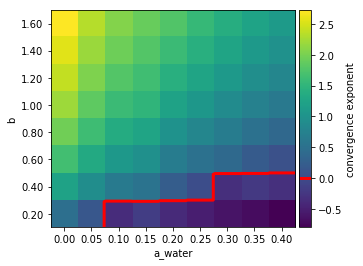

In [38]:
plt.figure()
ax = plt.gca()
discrete_plot.imshow_with_contours_and_zoom(
    a_water_list, 
    b_list[1:], 
    flux_diff_exponents[:,1:],
    contour_kwargs={
        'levels': [0],
        'linewidths': 3,
        'colors': 'red',
        'cmap': None
    },
    cbar_kwargs={
        'label': 'convergence exponent'
    },
    zoom_factor=4
)
ax.set_xlabel('a_water')
ax.set_ylabel('b')

### Convergence Exponents vs. $\varepsilon$

In [39]:
flat_iops = np.array([[[a_water, b] for b in b_list] for a_water in a_water_list]).reshape(len(a_water_list)*len(b_list), 2)
flat_a_water, flat_b = flat_iops.T
flat_eps = flat_b/(flat_a_water+flat_b)
flat_eps[0] = 0
flat_exponents = flux_diff_exponents.flatten()

/global/homes/o/oevans/local/miniconda3/envs/kelp/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [40]:
# Fit exponents
linear_f = lambda x, m, q: m*x + q
(m, q), _ = curve_fit(linear_f, flat_eps[flat_eps!=0], flat_exponents[flat_eps!=0])
eps_bnd = -q/m

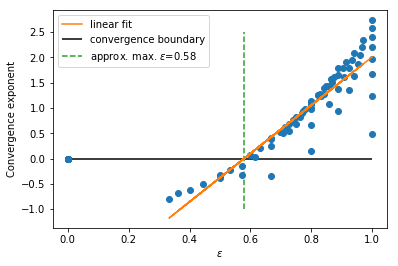

In [41]:
plt.plot(flat_eps, flat_exponents, 'o')
plt.hlines(0, np.nanmin(flat_eps), np.nanmax(flat_eps), label='convergence boundary')
plt.plot(flat_eps[flat_eps>0.3], linear_f(flat_eps[flat_eps>0.3], m, q), label='linear fit')
plt.vlines(
    eps_bnd, -1.0, 2.5,
    color='C2', linestyle='--', 
    label=r'approx. max. $\varepsilon$={:.2f}'.format(eps_bnd)
)
plt.xlabel(r'$\varepsilon$')
plt.ylabel('Convergence exponent')
plt.legend()

In [47]:
def plot_sweet_spots(a_water_list, b_list, ss_num_scatters, ss_errs, vmin=None, vmax=None):
    plt.figure()
    ax = plt.gca()
    if vmin is None:
        vmin = 1e-3
    if vmax is None:
        vmax = 5e3
        
    discrete_plot.imshow_with_contours_and_zoom(
        a_water_list, 
        b_list, 
        ss_errs,
        imshow_kwargs={
            'norm':LogNorm(
                vmin=vmin,
                vmax=vmax
            ),
        },
        contour_kwargs={
            'norm':LogNorm(
                vmin=vmin,
                vmax=vmax
            ),
        },
        cbar_kwargs={
            'label': 'Minimum relative error'
        },
        zoom_factor=4
    )
    ax.set_xlabel('a_water')
    ax.set_ylabel('b')

    # Write number of scatters
    for i, j in it.product(*map(range, ss_num_scatters.shape)):
        ax.text(
            i+0.5, j+0.5, 
            '{}'.format(ss_num_scatters[i,j]), 
            ha='center', 
            va='center'
        )
        
    

### Find sweet spot for each IOP set

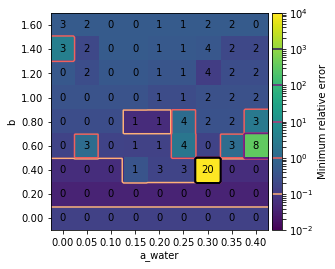

In [65]:
# Relative Errors
flux_rel_err_asym_vs_fd = np.abs((flux_grid_fd-flux_grid_as)/flux_grid_fd)
ss_rel_indices = np.argmin(flux_rel_err_asym_vs_fd, axis=2)
ss_rel_num_scatters = np.array(num_scatters_list)[ss_rel_indices]
ss_rel_min_errs = flux_rel_err_asym_vs_fd[[*map(range, ss_rel_indices.shape),ss_rel_indices]]
plot_sweet_spots(a_water_list, b_list, ss_rel_num_scatters, ss_rel_min_errs, vmin=1e-2, vmax=1e4)

### Smallest n for tolerance (good enough)

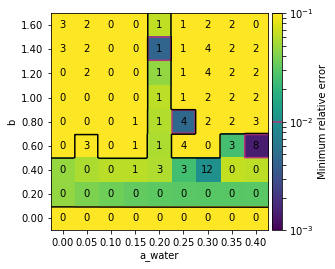

In [87]:
tol = 5e-2
ok_num_scatters = np.zeros([len(a_water_list), len(b_list)], dtype=int)
ok_rel_err = np.zeros_like(ok_num_scatters, dtype=float)
for i, a_water in enumerate(a_water_list):
    for j, b in enumerate(b_list):
        within_tol_inds = np.where(flux_rel_err_asym_vs_fd[i,j,:] <= tol)[0]
        # If any meet tol, use that value
        if len(within_tol_inds) > 0:
            min_ind = min(within_tol_inds)
        # Otherwise, just use smallest error
        else:
            min_ind = np.argmin(flux_rel_err_asym_vs_fd[i,j,:])
            
        ok_num_scatters[i,j] = num_scatters_list[min_ind]
        ok_rel_err[i,j] = flux_rel_err_asym_vs_fd[i,j,min_ind]
        
plot_sweet_spots(a_water_list, b_list, ok_num_scatters, ok_rel_err, vmin=1e-3, vmax=1e-1)

## Repeat both of the above plots, but compare to asymptote

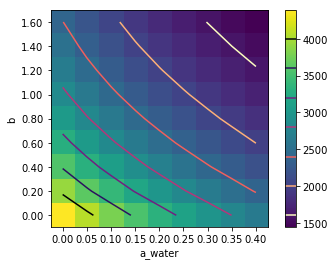

In [120]:
discrete_plot.imshow_with_contours(a_water_list, b_list, flux_grid_fd[:,:,0])
plt.xlabel('a_water')
plt.ylabel('b')

### Flux/error for all IOPs

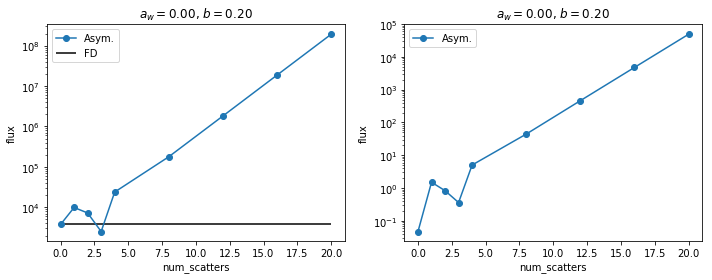

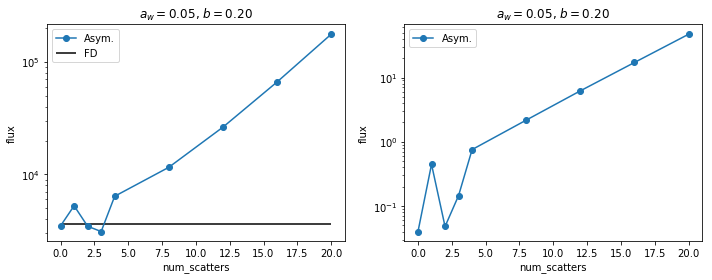

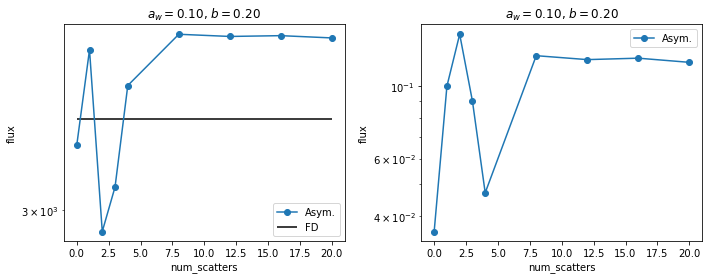

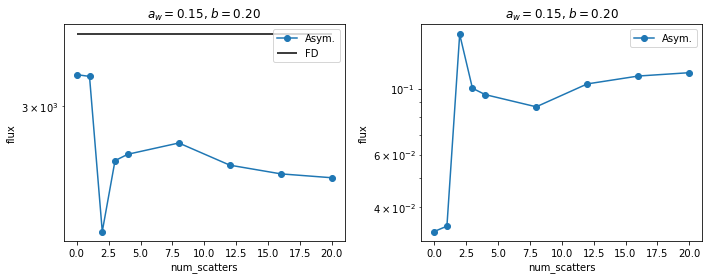

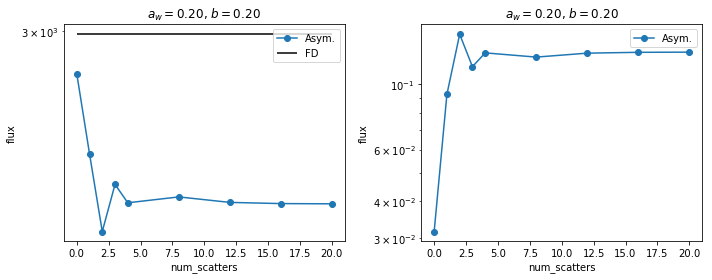

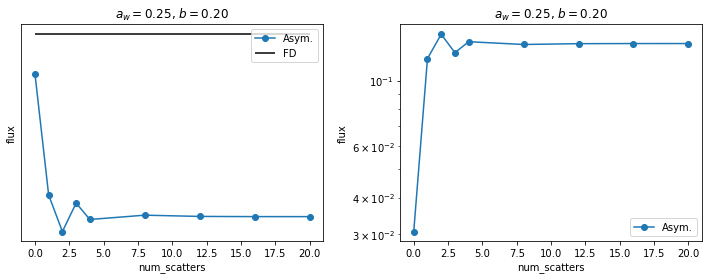

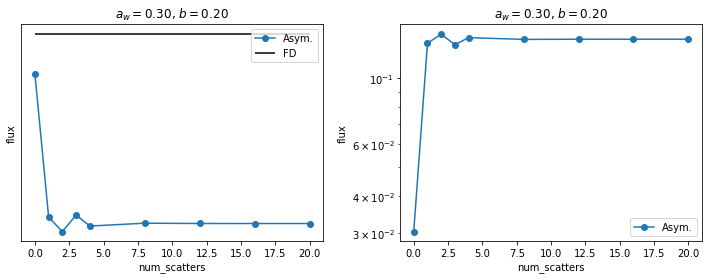

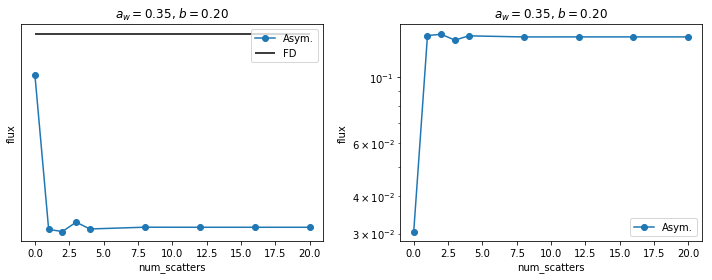

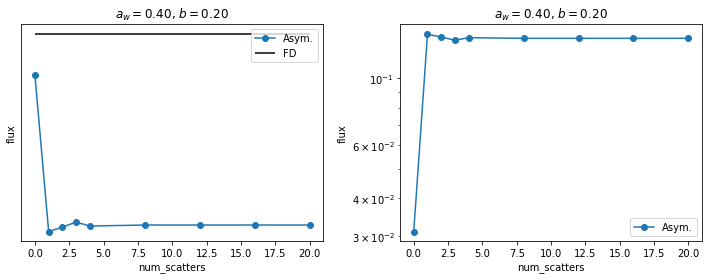

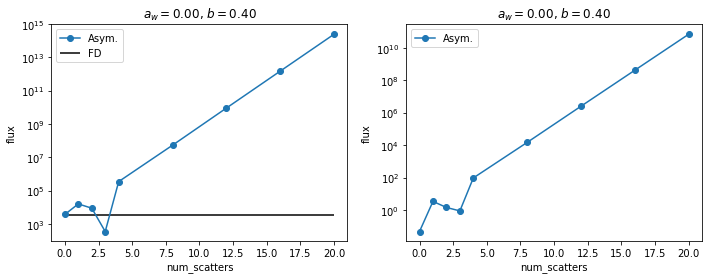

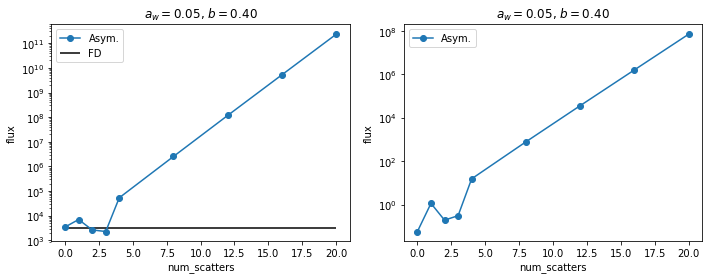

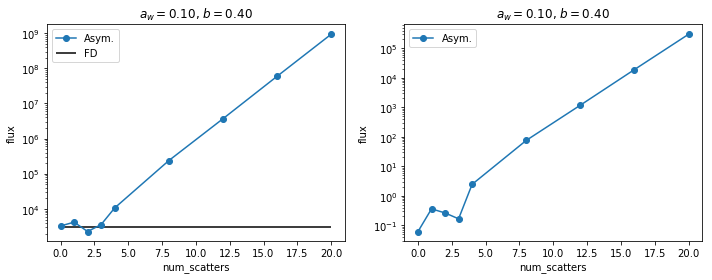

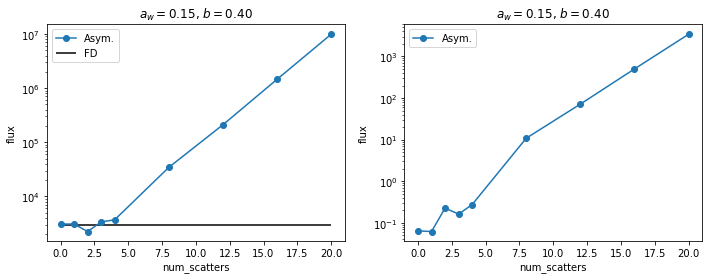

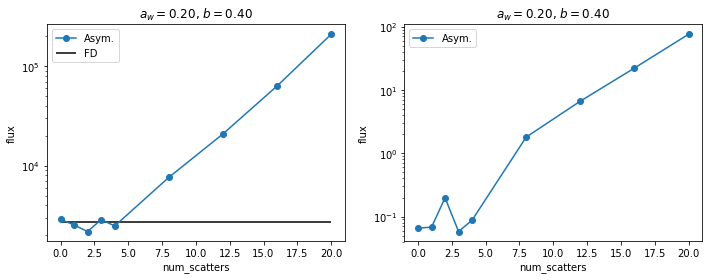

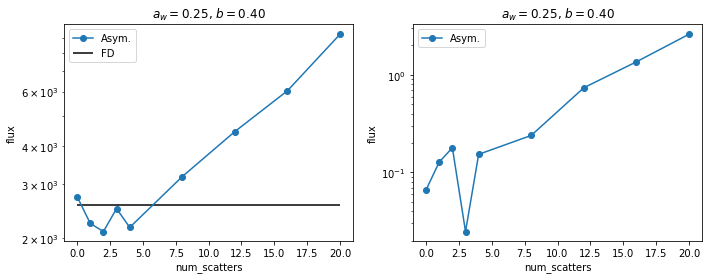

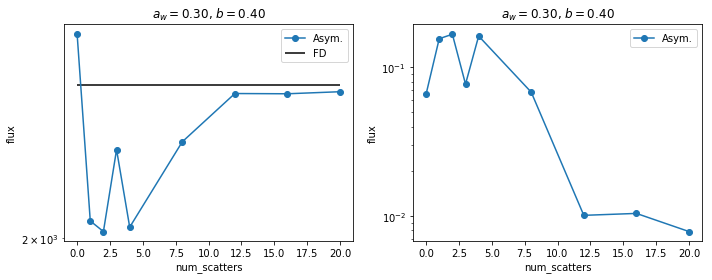

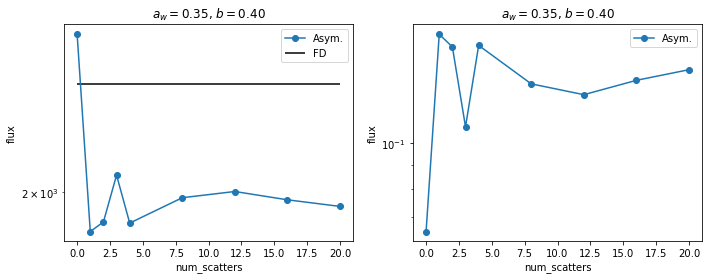

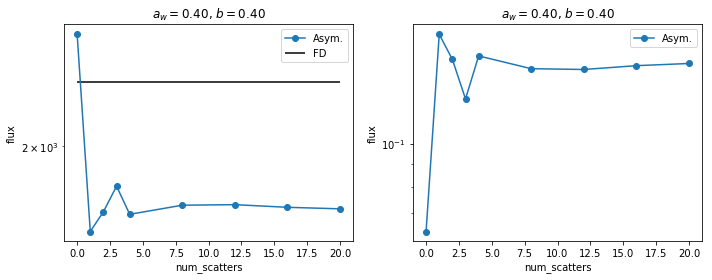

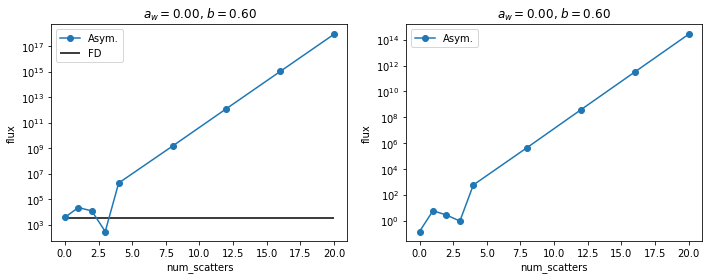

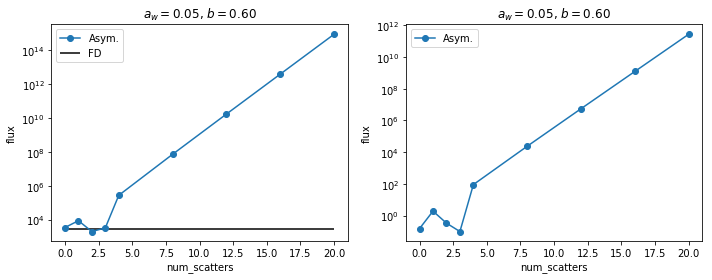

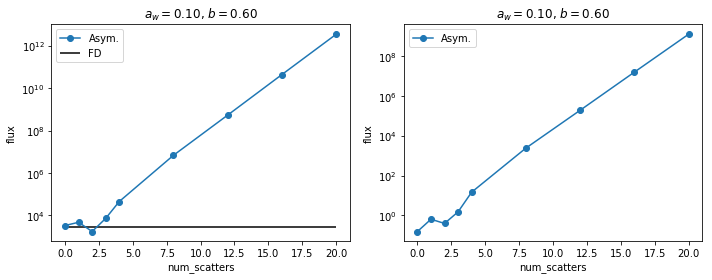

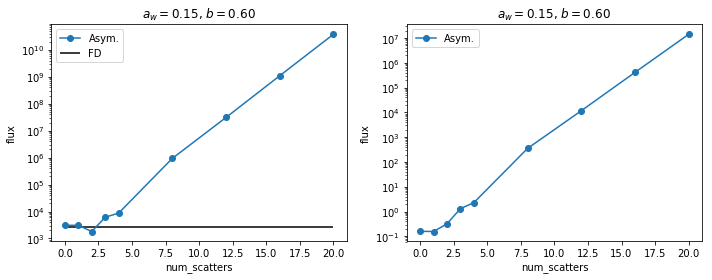

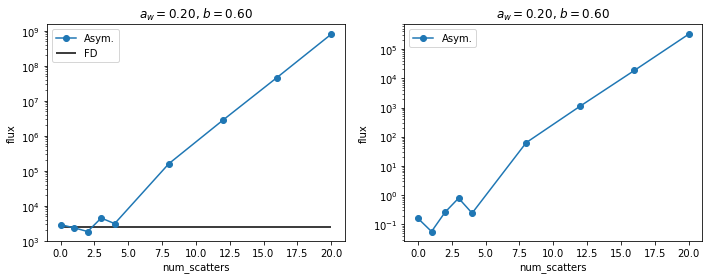

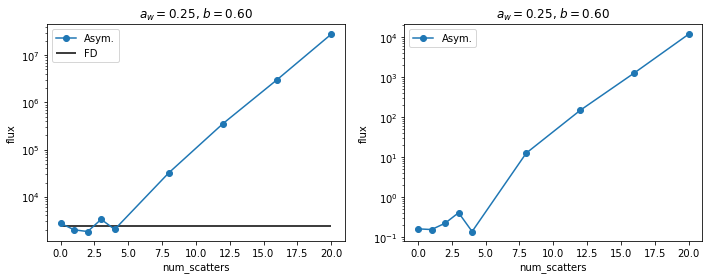

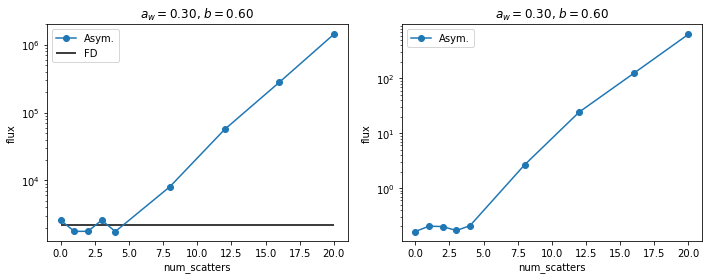

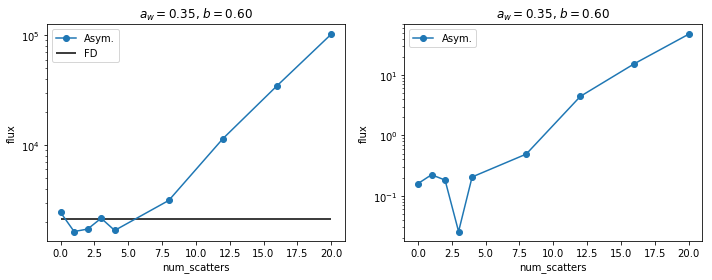

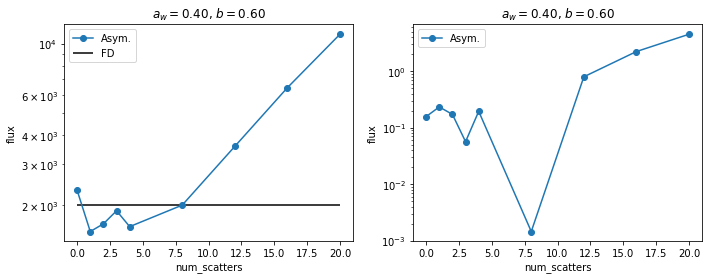

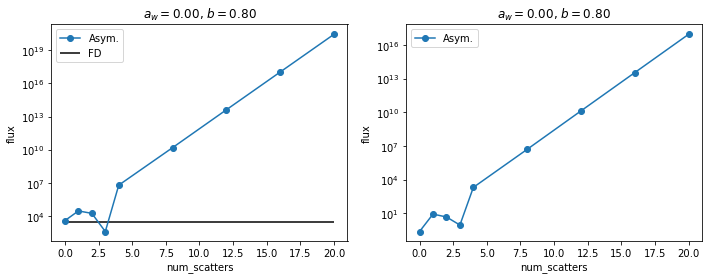

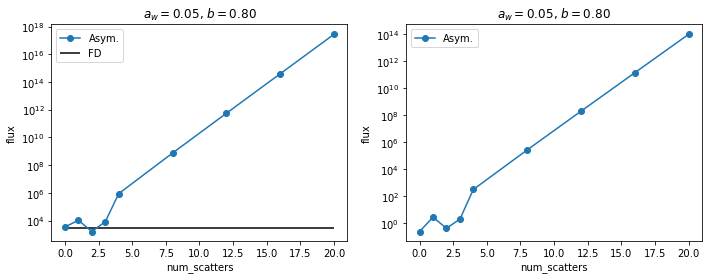

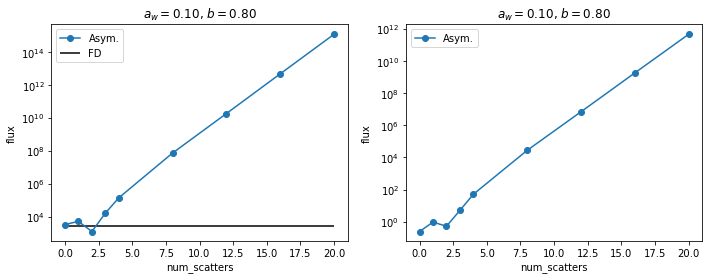

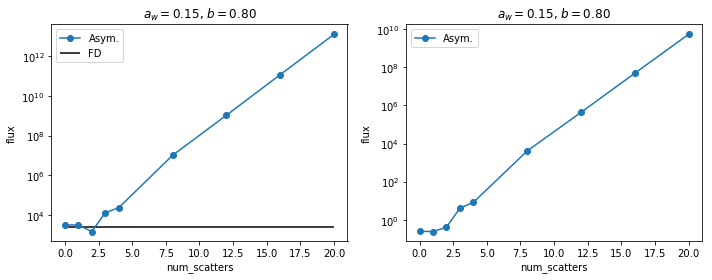

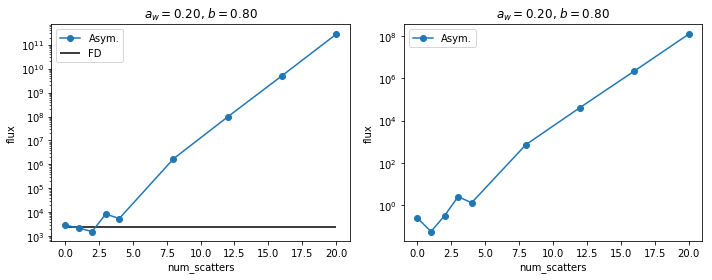

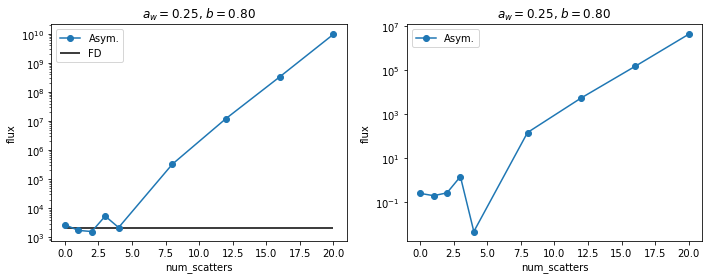

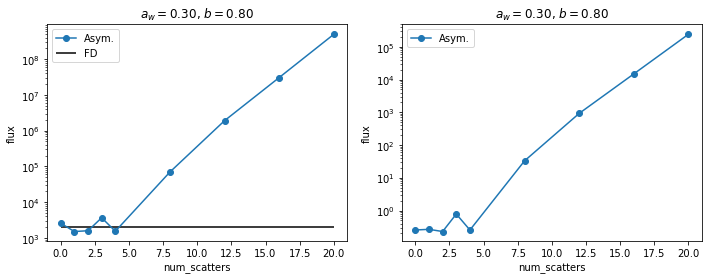

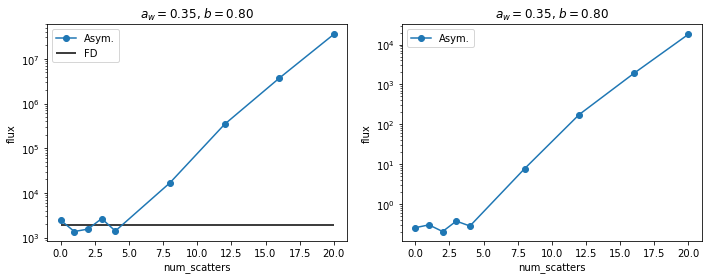

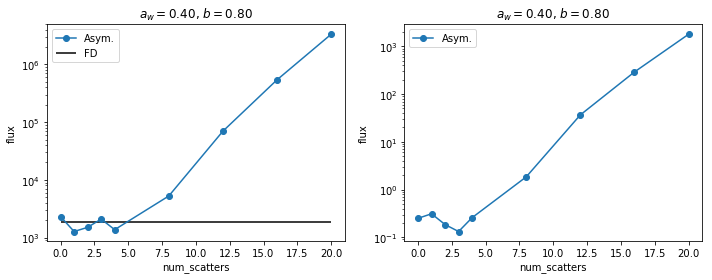

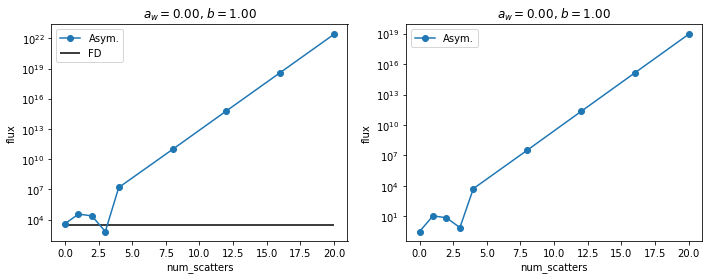

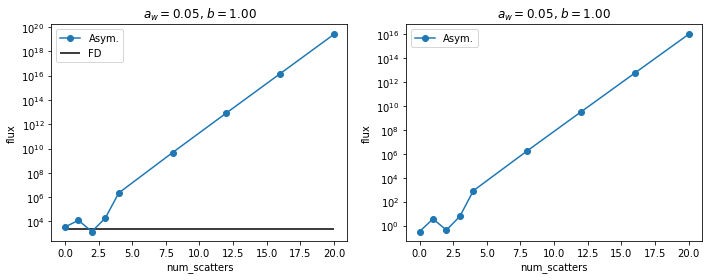

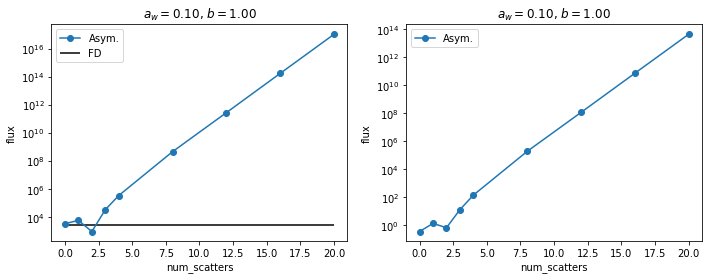

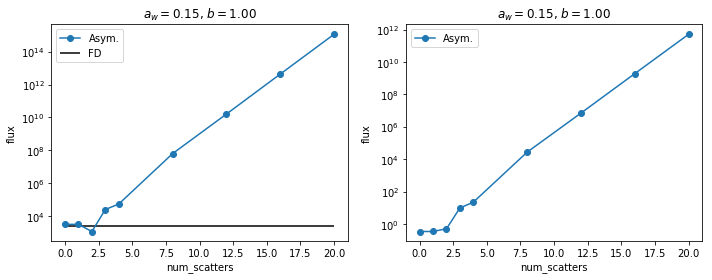

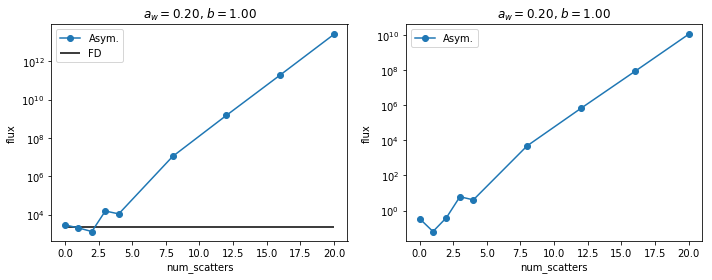

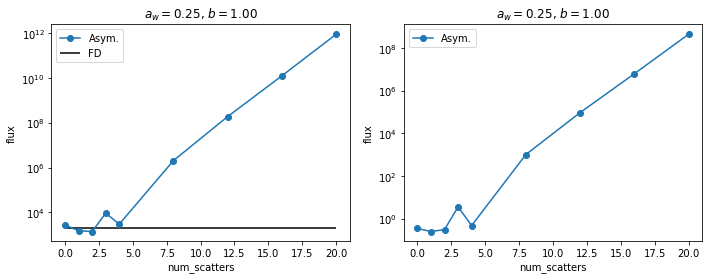

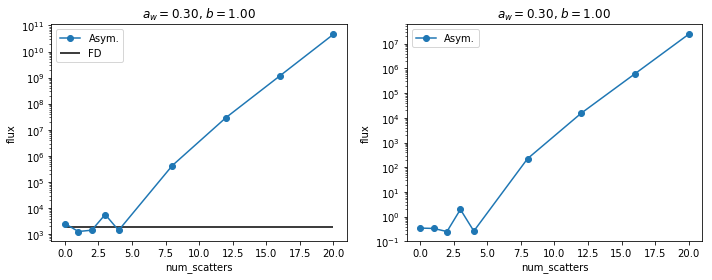

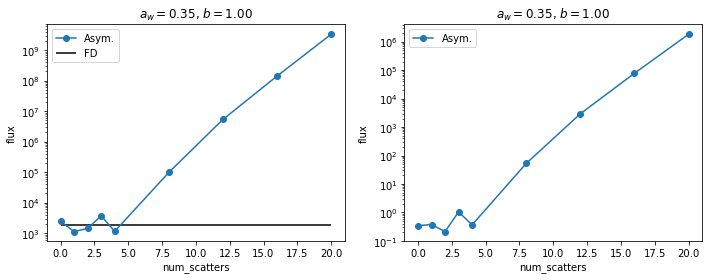

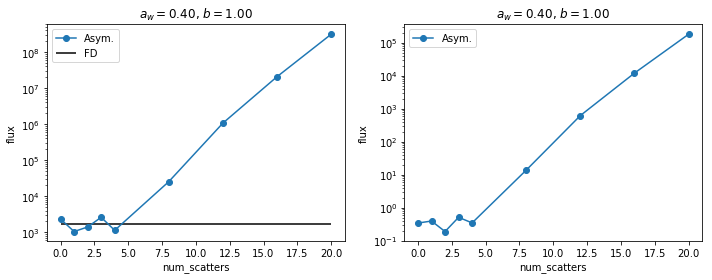

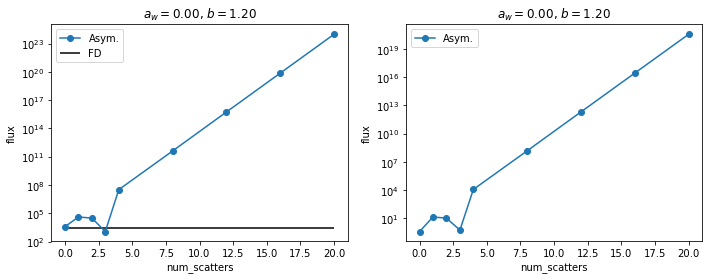

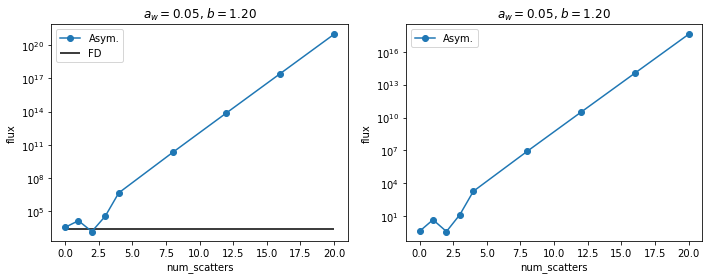

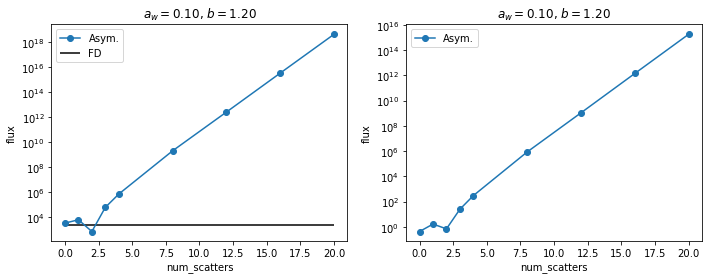

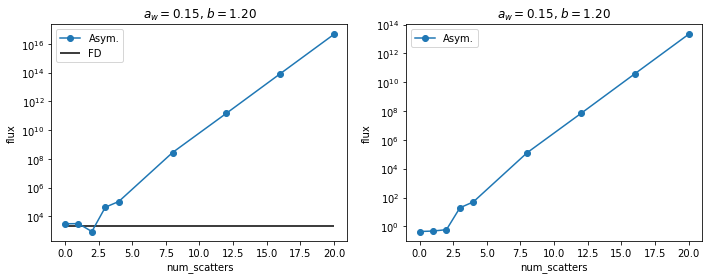

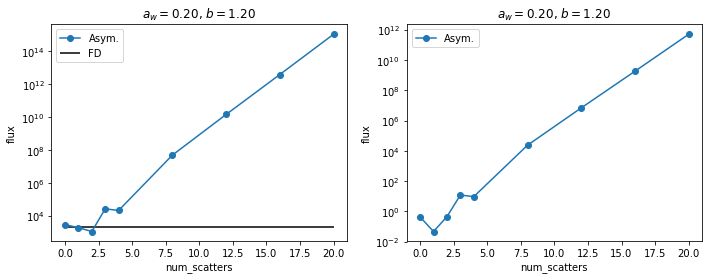

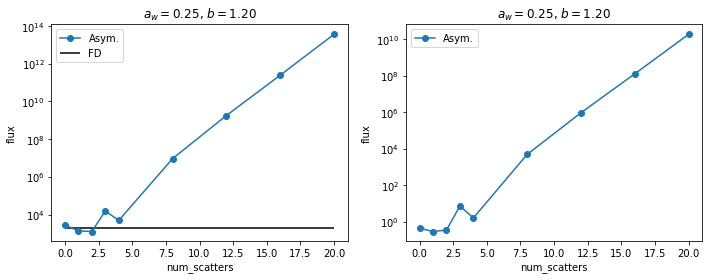

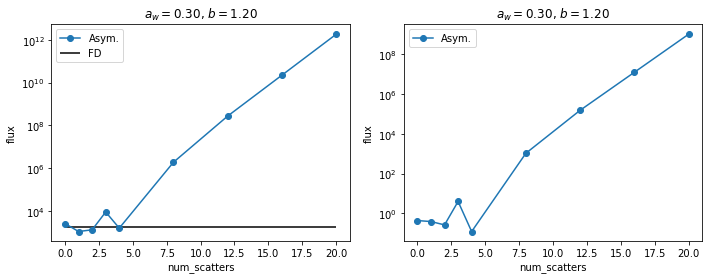

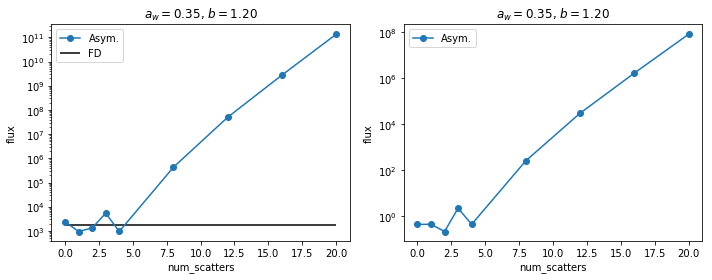

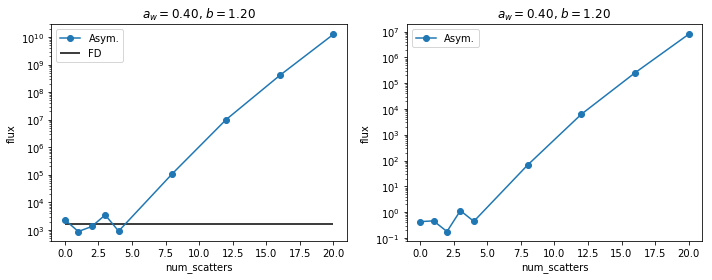

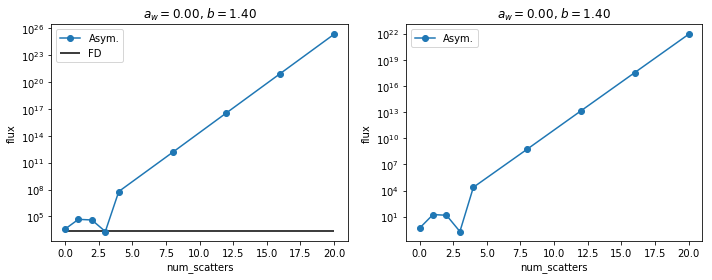

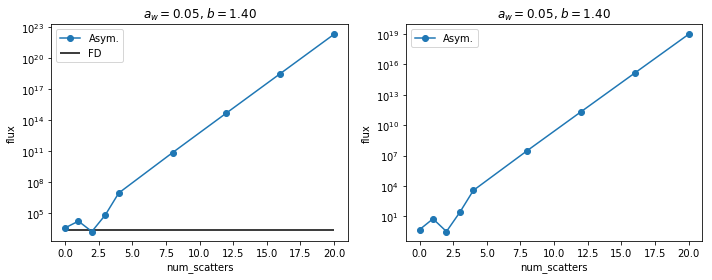

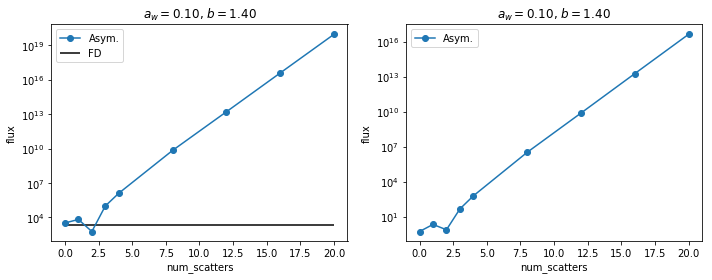

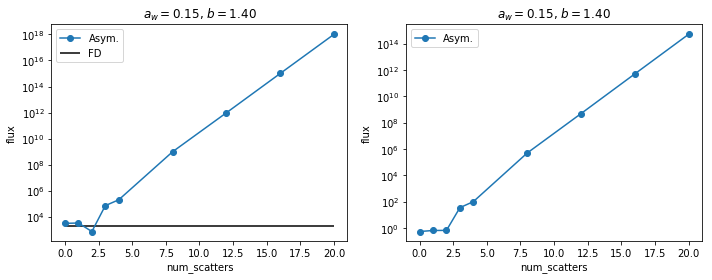

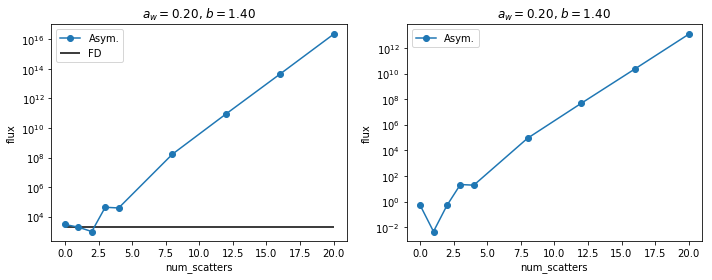

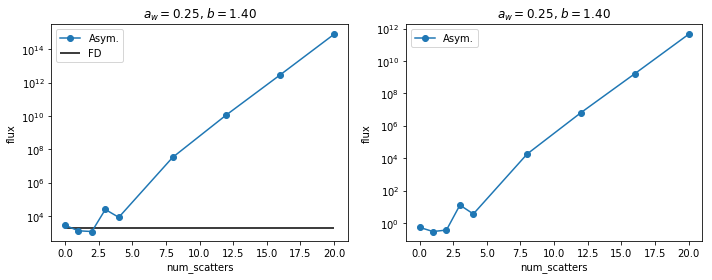

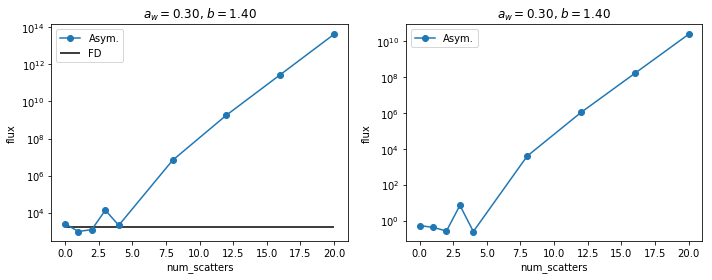

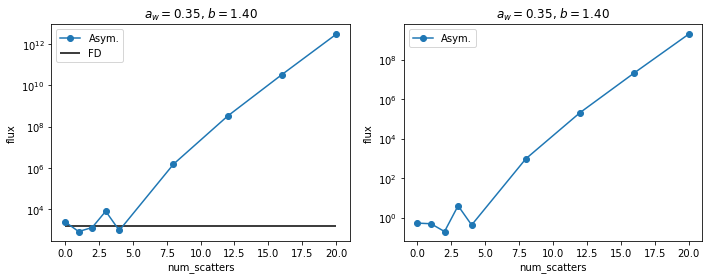

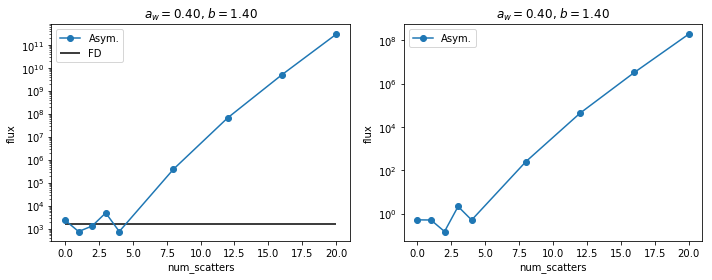

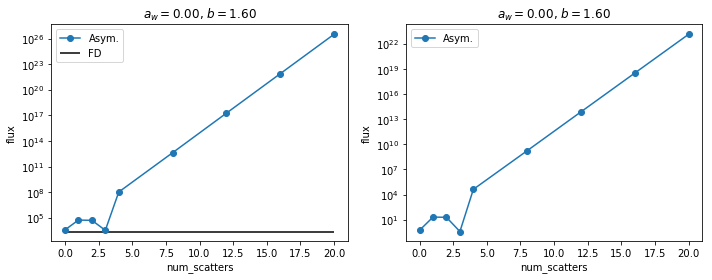

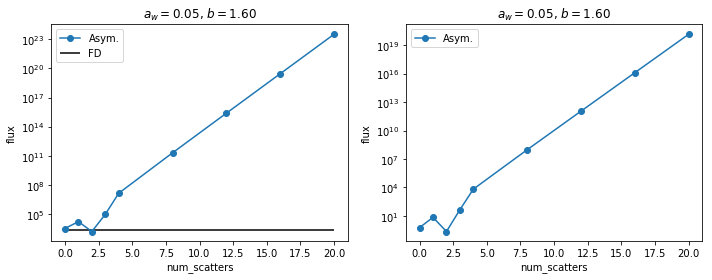

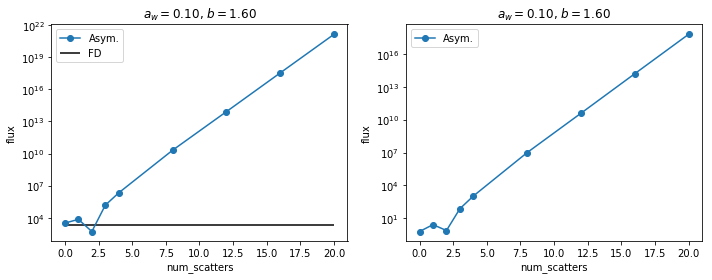

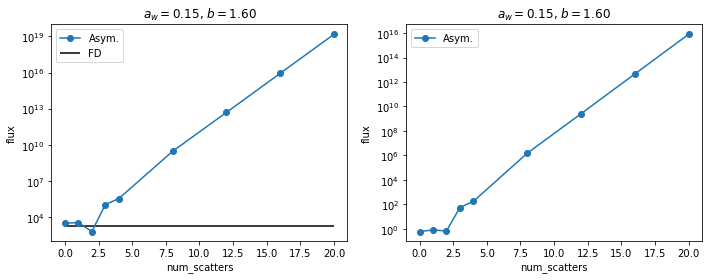

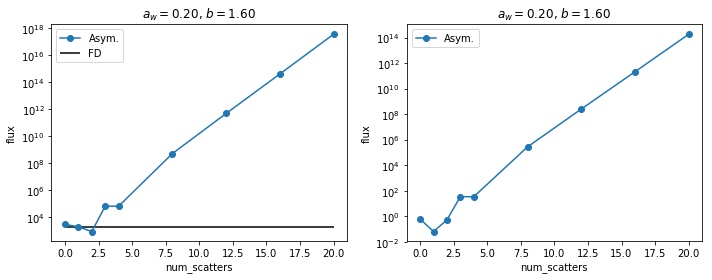

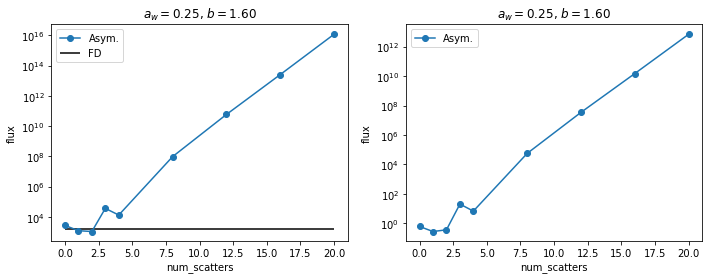

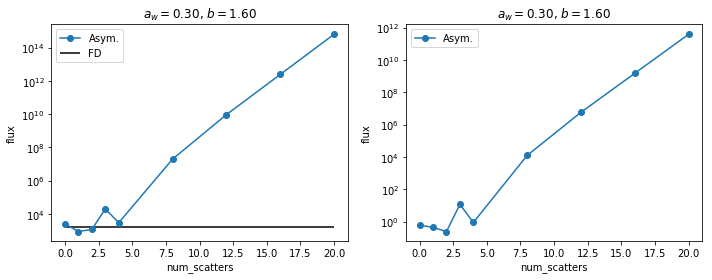

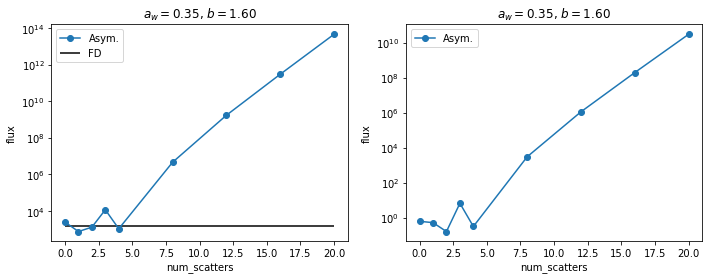

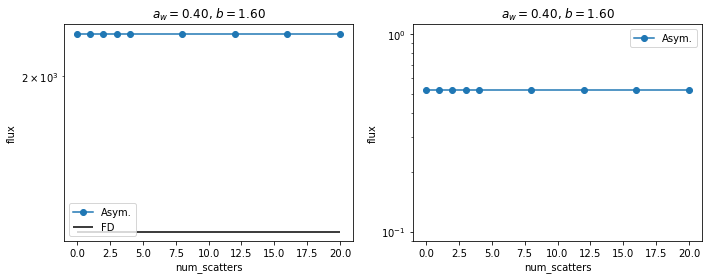

In [64]:
for j, b in enumerate(b_list):
    if b > 0:
        for i, a_water in enumerate(a_water_list):
            fig = plt.figure(figsize=(10,4))
            plt.subplot(1,2,1)
            plt.hlines(flux_grid_fd[i,j], min(num_scatters_list), max(num_scatters_list), label='FD')
            plt.plot(num_scatters_list, flux_grid_as[i,j,:], 'o-', label='Asym.')
            plt.yscale('log')
            plt.xlabel('num_scatters')
            plt.ylabel('flux')
            plt.title(r'$a_w={:.2f}$, $b={:.2f}$'.format(a_water, b))
            plt.legend()
            
            plt.subplot(1,2,2)
            plt.plot(num_scatters_list, flux_rel_err_asym_vs_fd[i,j,:], 'o-', label='Asym.')
            plt.yscale('log')
            plt.xlabel('num_scatters')
            plt.ylabel('flux')
            plt.title(r'$a_w={:.2f}$, $b={:.2f}$'.format(a_water, b))
            plt.legend()
            
            plt.tight_layout()
            plt.show()
            plt.close(fig)

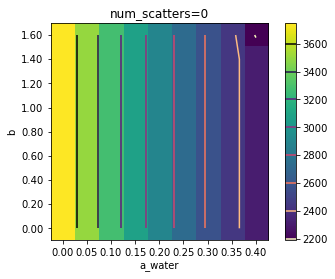

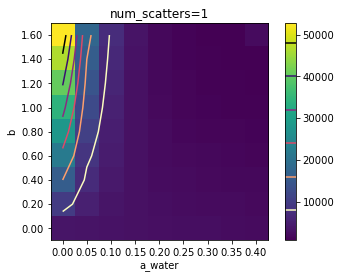

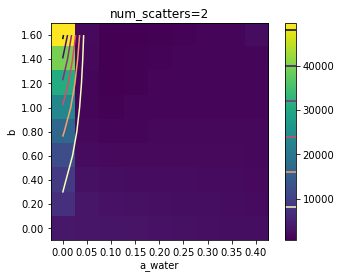

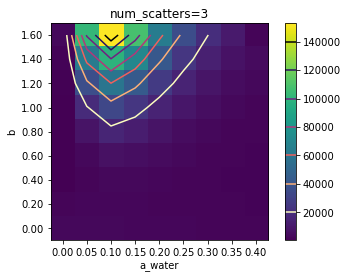

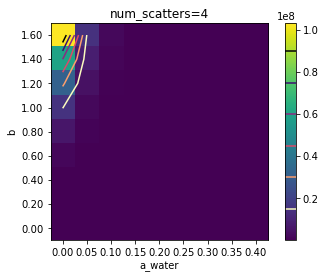

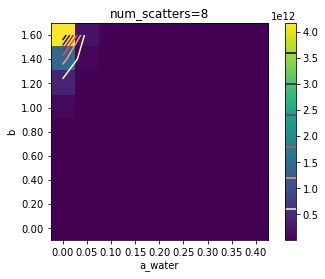

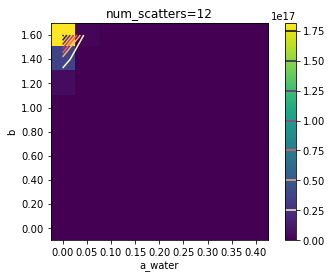

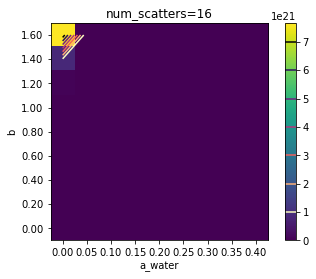

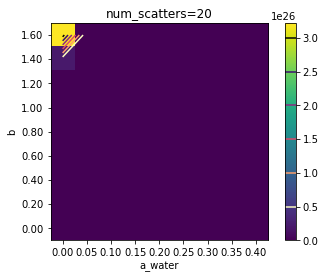

In [130]:
for i, num_scatters in enumerate(num_scatters_list):
    plt.figure()
    discrete_plot.imshow_with_contours(
        a_water_list, 
        b_list, 
        flux_grid_as[:,:,i]
    )
    plt.xlabel('a_water')
    plt.ylabel('b')
    plt.title('num_scatters={}'.format(num_scatters))

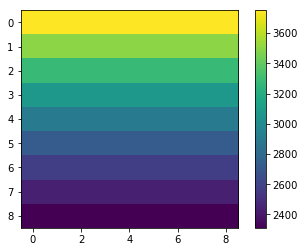

In [46]:
plt.imshow(flux_grid_as[:,:,0])
plt.colorbar()

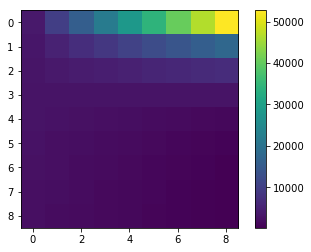

In [47]:
plt.imshow(flux_grid_as[:,:,1])
plt.colorbar()

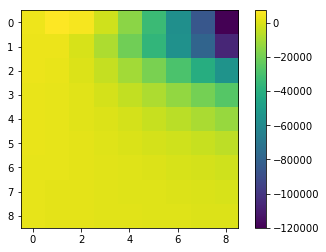

In [51]:
plt.imshow(flux_grid_as[:,:,2])
plt.colorbar()

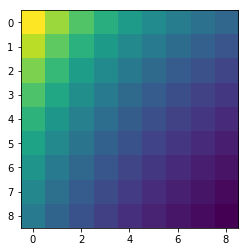

In [44]:
plt.imshow(flux_grid_fd[:,:,0])

## Plot Min. Num. Scatters to achieve tol.